In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution,  calculate_gaap_flux
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm
from numpy.fft import fft2, ifft2, fftshift
import importlib
from tqdm import tqdm
import cv2
from astropy.table import Table
from astropy.nddata import Cutout2D
import glob
import pickle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
from matplotlib.patches import Circle
from astropy.io import fits
warnings.filterwarnings("ignore")

In [3]:
def align_fluxes_by_reference(dfs, max_dist=2.0):
    # Find reference catalog (smallest)
    ref_band = min(dfs, key=lambda k: len(dfs[k]))
    ref_df = dfs[ref_band]
    ra_ref = ref_df['ra'].values
    dec_ref = ref_df['dec'].values
    ref_points = np.column_stack((ra_ref, dec_ref))

    bands = list(dfs.keys())
    flux_list = []

    for band in bands:
        df = dfs[band]
        ra = df['ra'].values
        dec = df['dec'].values
        points = np.column_stack((ra, dec))

        # Build KDTree and query nearest neighbor for each reference point
        tree = cKDTree(points)
        dist, idx = tree.query(ref_points, distance_upper_bound=max_dist)

        # Initialize flux array with NaNs
        flux_aligned = np.full(len(ref_points), np.nan)

        # Fill only valid matches
        valid = idx < len(df)
        flux_aligned[valid] = df['flux'].values[idx[valid]]

        flux_list.append(flux_aligned)

    # Combine into 2D array: rows = galaxies, columns = filters
    flux_matrix = np.column_stack(flux_list)
    return bands, flux_matrix

In [13]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

# Set the aperture size
aperture_size = 16

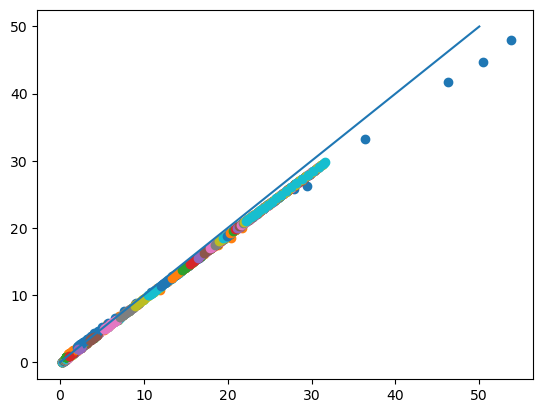

In [38]:
min_x, min_y = 800, 1000
max_x, max_y = 900, 1100
files = glob.glob(f'{location}/{field}/g_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")]
hdu1 = fits.open(image_file[0])[1]
wcs1 = WCS(hdu1.header)
files = glob.glob(f'{location}/{field}/DES-G_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")]
hdu2 = fits.open(image_file[0])[0]
wcs2 = WCS(hdu2.header)
dec_min, ra_min = wcs1.wcs_pix2world(min_x, min_y, 0)
dec_max, ra_max = wcs1.wcs_pix2world(max_x, max_y, 0)
x1, y1 = wcs2.wcs_world2pix(dec_min, ra_min, 0)
x2, y2 = wcs2.wcs_world2pix(dec_max, ra_max, 0)
y1, y2 = np.sort([y1, y2])
x1, x2 = np.sort([x1, x2])
image_1 = hdu1.data[int(min_y):int(max_y), int(min_x):int(max_x)]
image_2 = hdu2.data[int(y1):int(y2), int(x1):int(x2)]*10**((8.90 - 30)/2.5) * 10**9
image_2 = cv2.resize(image_2, (image_2.shape[1]//2, image_2.shape[0]//2),
                     interpolation=cv2.INTER_AREA)
for a in np.linspace(1, 8, 30):
    for b in np.linspace(1, 8, 30):
        weight = gaussian_weight(
                                image_1.shape[0],
                                image_1.shape[1],
                                image_1.shape[0] / a,
                                image_1.shape[1] / b,
                                aperture_size,
                                aperture_size
                            )
        plt.scatter(np.sum(image_1*weight), np.sum(4*image_2*weight))
plt.plot([0, 50], [0, 50])
plt.show()
# # fig, axes = plt.subplots(1, 2)
# plt.imshow(image_1, origin='lower', cmap='gray', vmin=np.percentile(image_1, 5), vmax=np.percentile(image_1, 95))
# circle = Circle(((image_1.shape[0])/2, (image_1.shape[1])/2), 10,
#                 edgecolor='red', facecolor='none', lw=2)

# plt.gca().add_patch(circle)
# plt.title('Rubin')
# plt.show()
# plt.imshow(image_2, origin='lower', cmap='gray', vmin=np.percentile(image_2, 5), vmax=np.percentile(image_2, 95))
# circle = Circle(((image_2.shape[0])/2, (image_2.shape[1])/2), 20,
#                 edgecolor='red', facecolor='none', lw=2)

# plt.gca().add_patch(circle)
# plt.title('Euclid')
# plt.show()
# plt.imshow(image_2-image_1, origin='lower' , cmap='gray')
# plt.colorbar()
# plt.show()
# print(np.sum(image_1*weight_1), np.sum(image_2*weight_2))

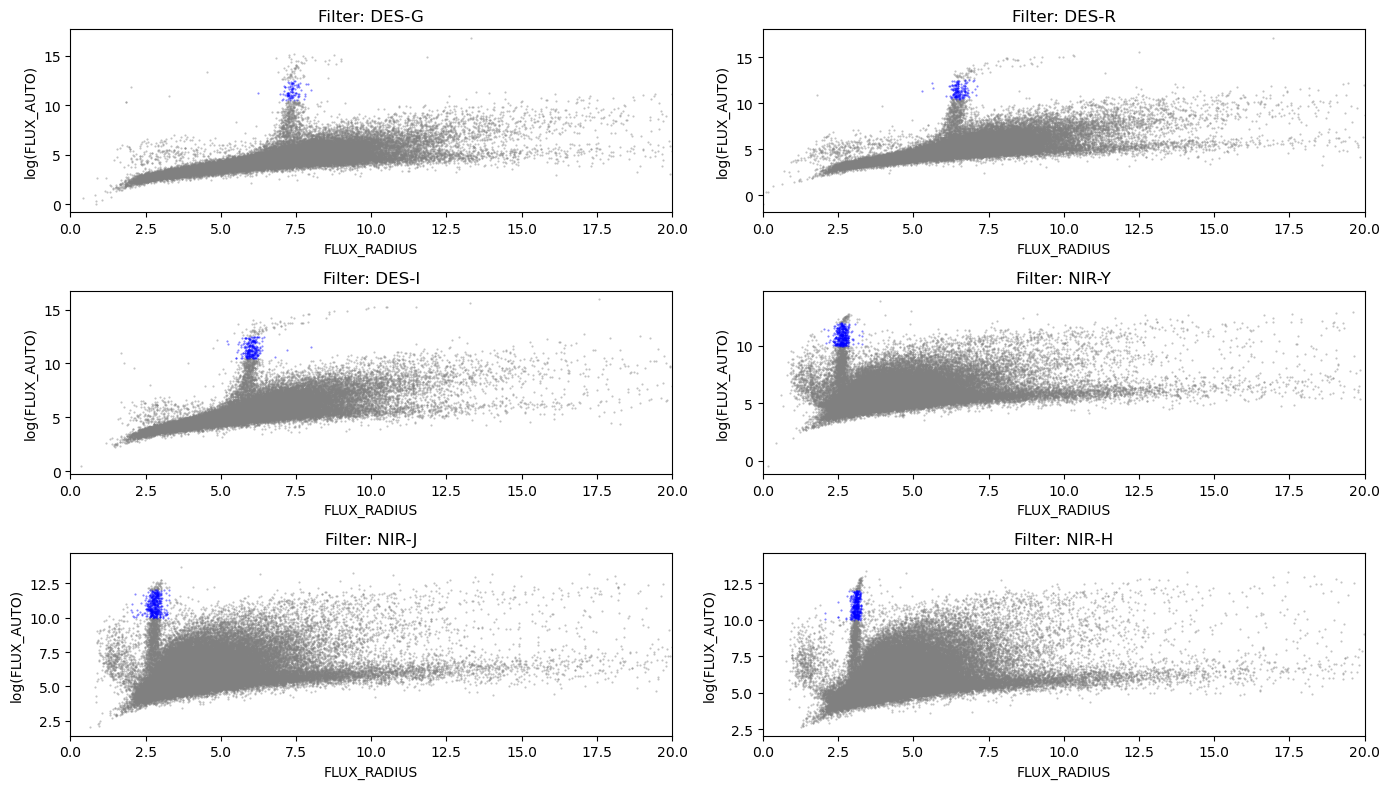

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
ax = ax.flatten()
filters = ['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
for i, filter in enumerate(filters):
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)
    if filter[:4] == 'DES-':
        mask = (
            (np.log(catalog['FLUX_AUTO']) > 10.5)
            & (np.log(catalog['FLUX_AUTO']) < 12.5)
            & (catalog['FLUX_RADIUS'] > 5)
            & (catalog['FLUX_RADIUS'] < 8.1)
        )
    else:
        mask = (
            (np.log(catalog['FLUX_AUTO']) > 10)
            & (np.log(catalog['FLUX_AUTO']) < 12)
            & (catalog['FLUX_RADIUS'] > 2)
            & (catalog['FLUX_RADIUS'] < 3.3)
        )
    ax[i].plot(catalog[~mask]['FLUX_RADIUS'], np.log(catalog[~mask]['FLUX_AUTO']), '.', ms=1, alpha=0.5, color='gray')
    ax[i].plot(catalog[mask]['FLUX_RADIUS'], np.log(catalog[mask]['FLUX_AUTO']), '.', ms=1, alpha=0.5, color='blue')
    ax[i].set_xlim(0, 20)
    ax[i].set_title(f'Filter: {filter}')
    ax[i].set_xlabel('FLUX_RADIUS')
    ax[i].set_ylabel('log(FLUX_AUTO)')
plt.tight_layout()
plt.show()

In [14]:
with open(f'{location}/{field}/aperture_{aperture_size/5}".pkl', 'rb') as f:
    dfs = pickle.load(f)
with open(f'{location}/{field}/sigma_aperture_{aperture_size/5}".pkl', 'rb') as f:
    sigma = pickle.load(f)

In [15]:
new_dfs = {}
for (band, df) in dfs.items():
    if len(band) > 1:
        new_dfs[band] = df[df['star']>=0.1]

In [16]:
bands, flux_matrix = align_fluxes_by_reference(new_dfs, max_dist=1/3600)
print(bands)
print(flux_matrix.shape)

['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
(649, 6)


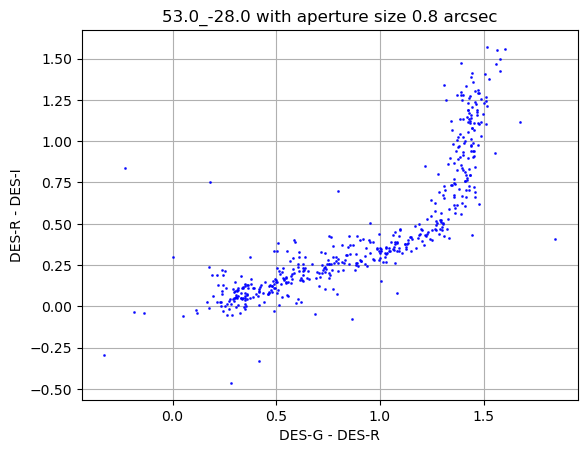

In [17]:
filter_1 = 0
filter_2 = 1
filter_3 = 1
filter_4 = 2


with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_3]/flux_matrix[:,filter_4])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_1]]/flux_matrix[:,filter_1])**2+(sigma[bands[filter_2]]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_3]]/flux_matrix[:,filter_3])**2+(sigma[bands[filter_4]]/flux_matrix[:,filter_4])**2)

    # xerr = np.zeros_like(x_color) 
    # yerr = np.zeros_like(y_color)
    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size/5} arcsec')
    # plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_3]} - {bands[filter_4]}')
    plt.show()

In [18]:
new_dfs = {}
for (band, df) in dfs.items():
    if len(band) > 1:
        new_dfs[band] = df[df['star']<=0.1]

In [19]:
bands, flux_matrix = align_fluxes_by_reference(new_dfs, max_dist=1/3600)
print(bands)
print(flux_matrix.shape)

['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
(41433, 6)


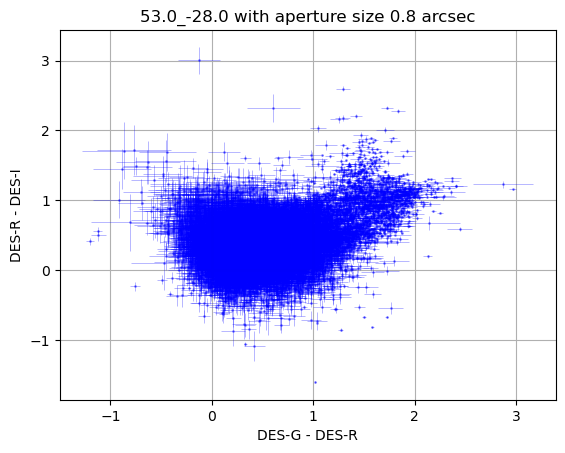

In [20]:
filter_1 = 0
filter_2 = 1
filter_3 = 1
filter_4 = 2


with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_3]/flux_matrix[:,filter_4])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_1]]/flux_matrix[:,filter_1])**2+(sigma[bands[filter_2]]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_3]]/flux_matrix[:,filter_3])**2+(sigma[bands[filter_4]]/flux_matrix[:,filter_4])**2)

    # xerr = np.zeros_like(x_color) 
    # yerr = np.zeros_like(y_color)
    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.4)
    plt.title(f'{field} with aperture size {aperture_size/5} arcsec')
    # plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_3]} - {bands[filter_4]}')
    plt.show()

In [21]:
bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=1/3600)
print(bands)
print(flux_matrix.shape)

['u', 'g', 'r', 'i', 'y', 'z', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
(1227, 12)


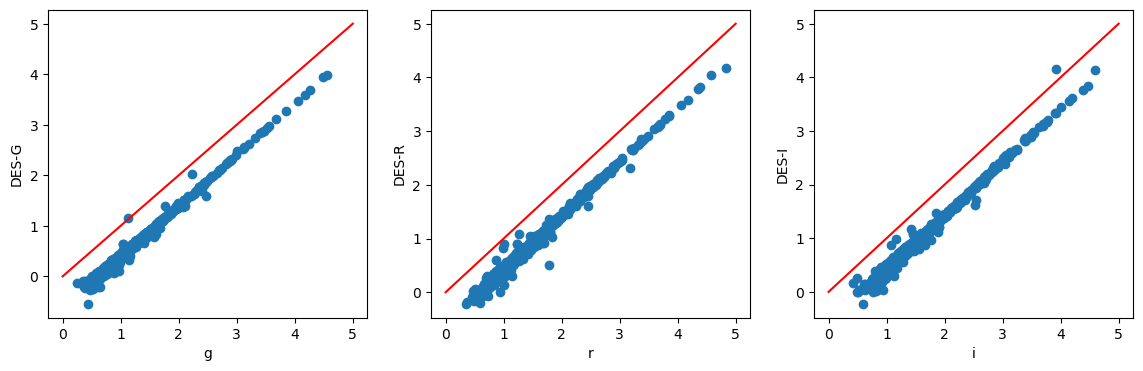

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    mask = ~np.isnan(flux_matrix[:,i+1]) & ~np.isnan(flux_matrix[:,i+6]) & (flux_matrix[:,i]>0) & (flux_matrix[:,i+6]>0)
    axes[i].scatter(np.log10(flux_matrix[mask,i+1]),np.log10(flux_matrix[mask,i+6]))
    axes[i].set_xlabel(bands[i+1])
    axes[i].set_ylabel(bands[i+6])
    axes[i].plot([0, 5], [0, 5], c='r')
plt.show()

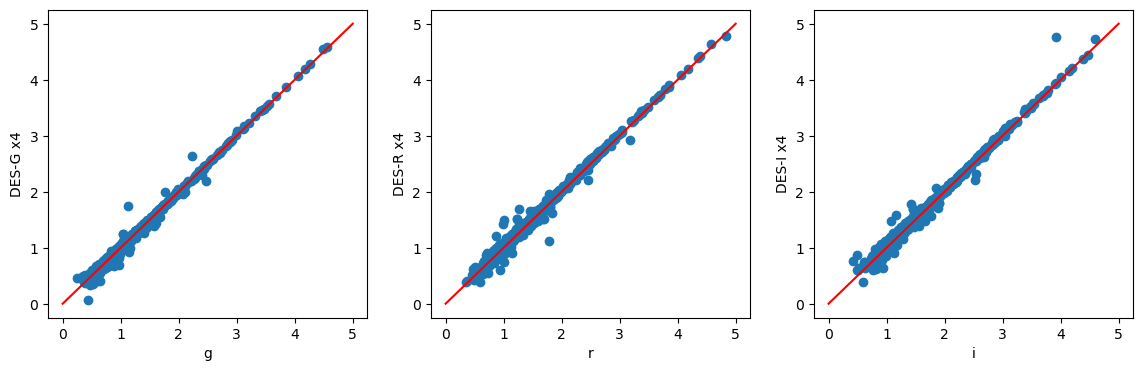

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    mask = ~np.isnan(flux_matrix[:,i+1]) & ~np.isnan(flux_matrix[:,i+6]) & (flux_matrix[:,i]>0) & (flux_matrix[:,i+6]>0)
    axes[i].scatter(np.log10(flux_matrix[mask,i+1]),np.log10(4*flux_matrix[mask,i+6]))
    axes[i].set_xlabel(bands[i+1])
    axes[i].set_ylabel(bands[i+6] + ' x4')
    axes[i].plot([0, 5], [0, 5], c='r')
plt.show()

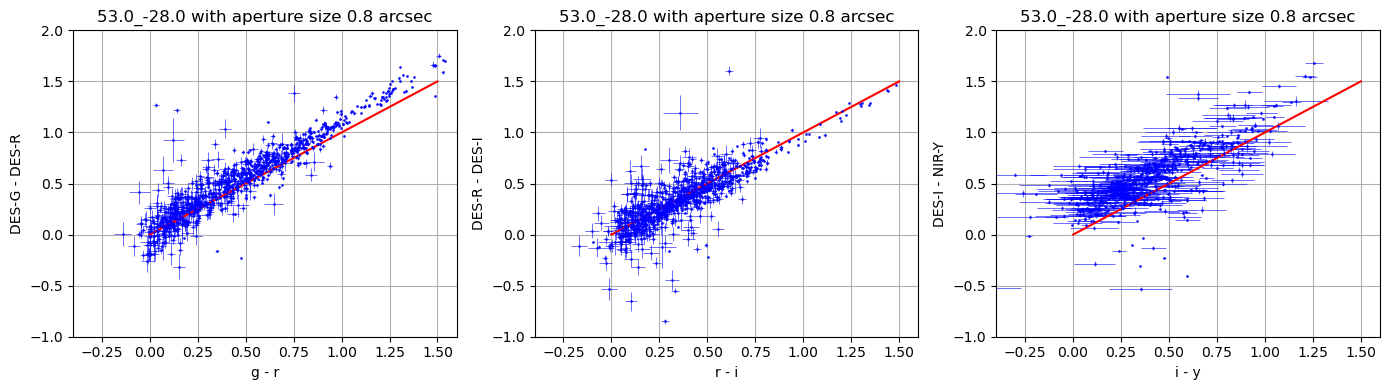

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    filter_1 = i+1
    filter_2 = i+2
    filter_3 = i+6
    filter_4 = i+7
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_3]/flux_matrix[:,filter_4])
    xerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_1]]/flux_matrix[:,filter_1])**2+(sigma[bands[filter_2]]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_3]]/flux_matrix[:,filter_3])**2+(sigma[bands[filter_4]]/flux_matrix[:,filter_4])**2)
    mask = (xerr**2 + yerr**2 < np.inf)
    axes[i].errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    axes[i].set_title(f'{field} with aperture size {aperture_size/5} arcsec')
    axes[i].grid(True)
    axes[i].set_xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    axes[i].set_ylabel(f'{bands[filter_3]} - {bands[filter_4]}')
    axes[i].set_xlim(-0.4, 1.6)
    axes[i].set_ylim(-1, 2)
    axes[i].plot([0, 1.5], [0, 1.5], c='r')
plt.tight_layout()
plt.show()

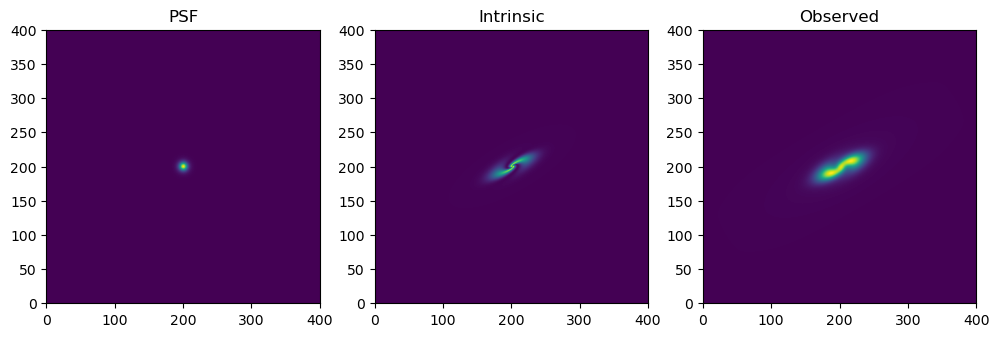

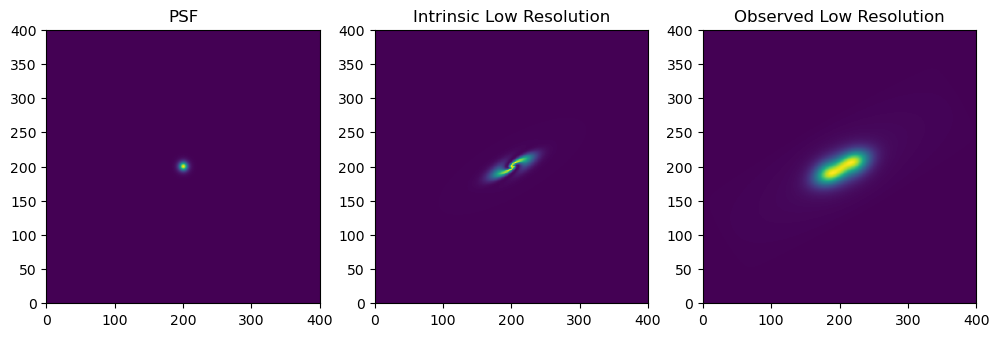

In [25]:
width = 400
height = 400

# Create PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)
image_intrinsic_low_res = cv2.resize(image_intrinsic, (width//2, height//2), interpolation=cv2.INTER_AREA)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")
image_low_res = fftconvolve(image_intrinsic_low_res, image_psf, mode="same")
# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic_low_res, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic Low Resolution")
axs[2].imshow(image_low_res, extent=(0, width, 0, height))
axs[2].set_title("Observed Low Resolution")
plt.show()

In [26]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
true_F_low_res = np.sum(weight_low_res*image_intrinsic_low_res)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}, {true_F_low_res:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, _ = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
measured_F_low_res, _ = calculate_gaap_flux(image_low_res, image_psf, weight_low_res, [(height / 4, width / 4)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}, {measured_F_low_res[0]:.6}')

The aperture flux measured using the intrinsic image and weight function : 0.252183, 0.251964
The aperture flux using the observed image and rescaled weight function : 0.252183, 0.251964
